In [124]:
library(tidyverse)
library(stringr)

In [125]:
#Main result

In [126]:
fn_vec_itt

[1] "../Data/psw_test_csv/bs_simulation_1_1_1_10.csv" 
[2] "../Data/psw_test_csv/N_simulation_1_1_1_10.csv"  
[3] "../Data/psw_test_csv/psw_simulation_1_1_1_10.csv"

In [127]:
fn_vec <- list.files("../Data/psw_test_csv",full.names = T)

N_vec = c(30)
C_vec = c(0.2)
a_vec = c(0.75)
Nchunk = 10

N_list <- list()
psw_list <- list()
bs_list <- list()

for(N in 1:length(N_vec)){
    for(C in 1:length(C_vec)){
        for(a in 1:length(a_vec)){
            for(chunk in 1:Nchunk){
                fn_vec_itt <- fn_vec[str_detect(fn_vec, paste0(paste("simulation",N,C,a,chunk,sep = "_"), ".csv"))]
                    for(i in 1:length(fn_vec_itt)){
                        df <- read_tsv(fn_vec_itt[i],col_names = FALSE, show_col_types = FALSE)
                        colnames(df) <- c("time","treat", paste0("rep_", 200*(chunk-1) + 1:200))
                        df$temp <- rep(1:50, 4)
                        df <- df %>% pivot_longer(cols = -c(time,treat,temp),names_to = "rep",values_to = "val") 
                        df$N <- N_vec[N]
                        df$C <- C_vec[C]
                        df$a <- a_vec[a]

                        df <- df %>%
                                mutate(time = ifelse(time, "After Dispersal", "Before Dispersal"),
                                       treat = ifelse(treat, "Random","Allometric"))

                        if(str_detect(fn_vec_itt[i], "N_")){

                            N_list[[ length(N_list) + 1 ]] <- df
                        }else if(str_detect(fn_vec_itt[i], "bs_")){
                            bs_list[[  length(bs_list) + 1 ]] <- df
                        } else {
                            psw_list[[ length(psw_list) + 1 ]] <- df 
                        }
            }
          } 
        }
    }
}

df_N <- bind_rows(N_list) %>% rename(N_obs = val)
df_psw <- bind_rows(psw_list) %>% rename(psw = val)
df_bs <- bind_rows(bs_list) %>% rename(bs = val)
df <- list(df_N, df_psw, df_bs) %>% reduce(full_join)

Joining, by = c("time", "treat", "temp", "rep", "N", "C", "a")
Joining, by = c("time", "treat", "temp", "rep", "N", "C", "a")


`summarise()` has grouped output by 'param', 'time', 'temp'. You can override using the `.groups` argument.


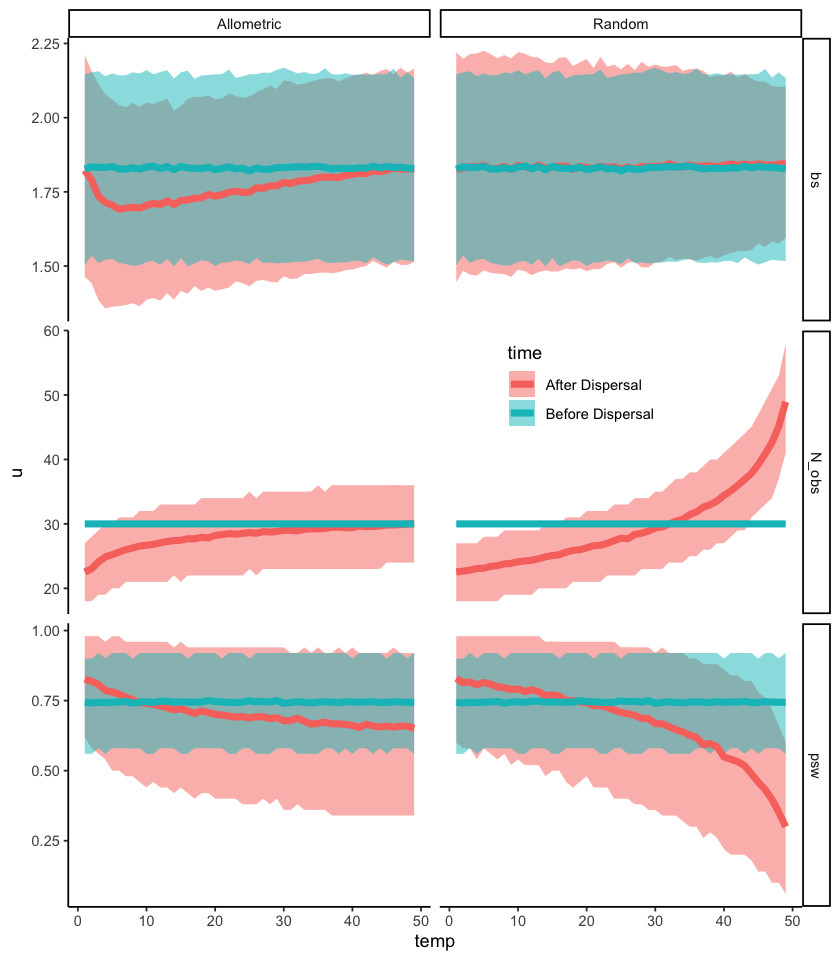

In [128]:
options(repr.plot.width=7, repr.plot.height=8)

psw_result <- df %>%
    pivot_longer(c(N_obs,psw,bs), names_to = "param", values_to = "val") %>%
    filter(temp != 50) %>%
    group_by(param,time,temp,treat) %>%
    summarise(u = mean(val), lb = quantile(val, 0.05), ub = quantile(val,0.95)) %>%
    ggplot(aes(temp, u, fill = time, group = time)) +
        geom_ribbon(aes(ymin = lb, ymax = ub), alpha = 0.5) +
        geom_line(aes(color = time), size = 2)+
        facet_grid(param~treat, scale = "free_y")+
        theme_classic()+
        theme(legend.position = c(0.7, 0.6))

ggsave("../Figures/f1_psw_main.pdf", width = 7, height = 4)

psw_result

In [1]:
df %>% 
    filter(temp != 50, time == "After Dispersal") %>%    
    group_by(temp,treat) %>%
    summarise(psw = mean(psw), bs = mean(bs), N_obs = mean(N_obs)) %>%
    ggplot(aes(N_obs, psw, color = temp))+
        geom_point(alpha = 1)+
        # stat_summary()+÷\
        facet_grid(~treat, scales = 'free')
        # geom_smooth(method = 'lm')

ERROR: Error in df %>% filter(temp != 50, time == "After Dispersal") %>% group_by(temp, : could not find function "%>%"


In [131]:
options(repr.plot.width=10, repr.plot.height=4)

psw_result <- df_N %>%
    filter(temp != 50) %>%
    group_by(time,temp,treat) %>%
    summarise(u = mean(val), lb = quantile(val, 0.05), ub = quantile(val,0.95)) %>%
    ggplot(aes(temp, u, fill = time, group = time)) +
        geom_ribbon(aes(ymin = lb, ymax = ub), alpha = 0.5) +
        geom_line(aes(color = time), size = 2)+
        facet_grid(~treat)+
        theme_classic()+
        theme(legend.position = c(0.7, 0.2))

ggsave("../Figures/f1_psw_main.pdf", width = 7, height = 4)

psw_result

ERROR: [1m[33mError[39m in [1m[1m`summarise()`:[22m
[1m[22m[33m![39m Problem while computing `u = mean(val)`.
[36mℹ[39m The error occurred in group 1: time = "After Dispersal", temp = 1, treat = "Allometric".
[1mCaused by error in [1m[1m`mean()`:[22m
[33m![39m object 'val' not found


`summarise()` has grouped output by 'time', 'temp'. You can override using the `.groups` argument.


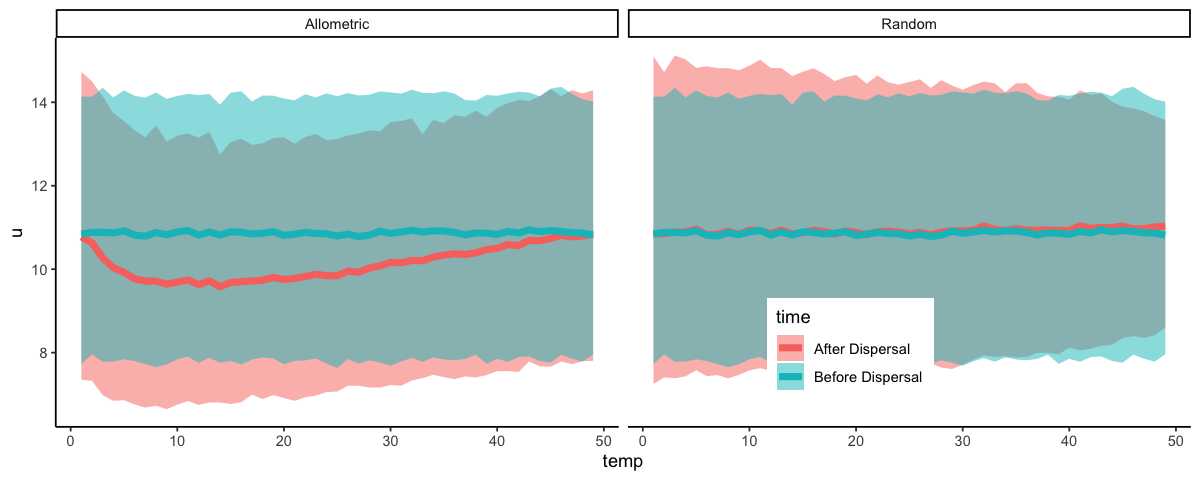

In [82]:
options(repr.plot.width=10, repr.plot.height=4)

psw_result <- df_bs %>%
    filter(temp != 50) %>%
    group_by(time,temp,treat) %>%
    summarise(u = mean(val), lb = quantile(val, 0.05), ub = quantile(val,0.95)) %>%
    ggplot(aes(temp, u, fill = time, group = time)) +
        geom_ribbon(aes(ymin = lb, ymax = ub), alpha = 0.5) +
        geom_line(aes(color = time), size = 2)+
        facet_grid(~treat)+
        theme_classic()+
        theme(legend.position = c(0.7, 0.2))

ggsave("../Figures/f1_psw_main.pdf", width = 7, height = 4)

psw_result

In [188]:
fn_vec <- list.files(".") 

N_vec = c(10,20,30)
C_vec = c(0.1, 0.2, 0.3)
a_vec = c(-0.75, -0.25, 0.0, 0.25, 0.75)

k <- 1

psw_list <- list()

for(N in 1:3){
    for(C in 1:length(C_vec)){
        for(a in 1:length(a_vec)){
            fn_vec_itt <- fn_vec[str_detect(fn_vec, paste("psw_simulation",N,C,a,sep = "_"))]

            for(i in 1:length(fn_vec_itt)){
                df <- read_tsv(fn_vec_itt[i],col_names = FALSE, show_col_types = FALSE)
                colnames(df) <- c("time","treat", paste0("rep_", 100*(i-1) + 1:100))
                df$temp <- rep(1:50, 4)
                df <- df %>% pivot_longer(cols = -c(time,treat,temp),names_to = "rep",values_to = "psw") 
                df$N <- N_vec[N]
                df$C <- C_vec[C]
                df$a <- a_vec[a]
                
                psw_list[[k]] <- df
                
                k <- k + 1
           } 
        }
    }
}


In [189]:
psw_df <- bind_rows(psw_list)

`summarise()` has grouped output by 'time', 'temp', 'N', 'C'. You can override using the `.groups` argument.


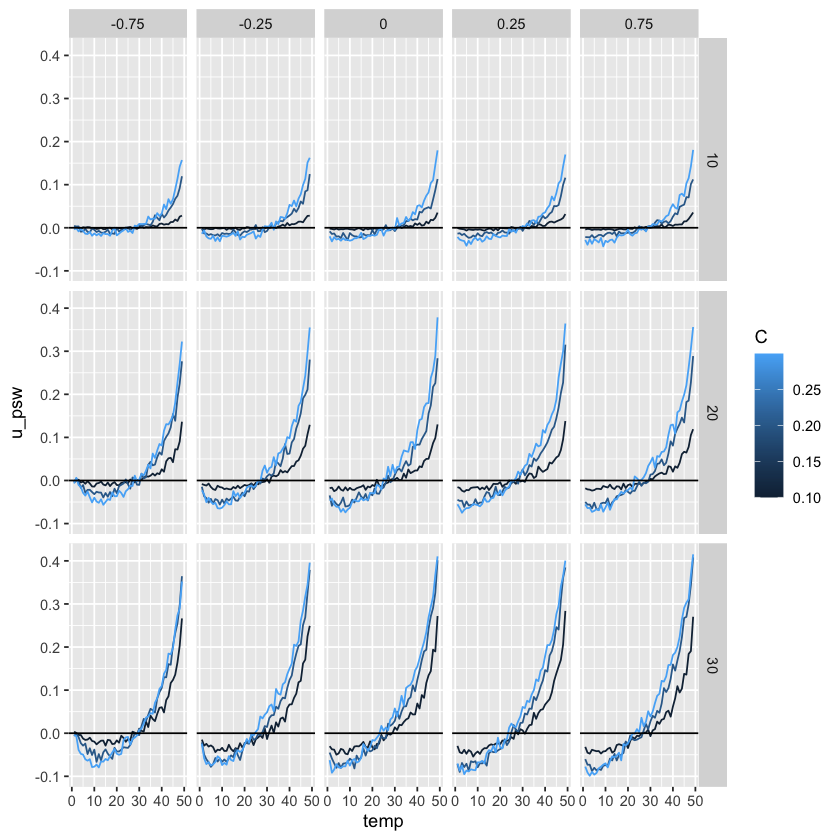

In [191]:
psw_df %>%
    filter(time == 1, temp != 50) %>%
    pivot_wider(names_from = treat, values_from = psw ) %>%
    mutate(diff = `0` - `1`) %>%
    group_by(time,temp,N,C,a) %>%
    summarise(u_psw = mean(diff)) %>%
    ggplot(aes(temp, u_psw, group = C, color = C)) +
        geom_line()+
        facet_grid(N~a)+
        geom_hline(yintercept = 0)

In [181]:
fn_vec <- list.files(".") 

N_vec = c(10,20,30)
C_vec = c(0.1, 0.2, 0.3)
a_vec = c(-0.75, -0.25, 0.0, 0.25, 0.75)

k <- 1

bs_list <- list()

for(N in 1:3){
    for(C in 1:length(C_vec)){
        for(a in 1:length(a_vec)){
            fn_vec_itt <- fn_vec[str_detect(fn_vec, paste("bs_simulation",N,C,a,sep = "_"))]

            for(i in 1:length(fn_vec_itt)){
                df <- read_tsv(fn_vec_itt[i],col_names = FALSE, show_col_types = FALSE)
                colnames(df) <- c("time","treat", paste0("rep_", 100*(i-1) + 1:100))
                df$temp <- rep(1:50, 4)
                df <- df %>% pivot_longer(cols = -c(time,treat,temp),names_to = "rep",values_to = "psw") 
                df$N <- N_vec[N]
                df$C <- C_vec[C]
                df$a <- a_vec[a]
                
                bs_list[[k]] <- df
                
                k <- k + 1
           } 
        }
    }
}


In [182]:
bs_df <- bind_rows(bs_list)

`summarise()` has grouped output by 'N', 'treat', 'temp', 'C'. You can override using the `.groups` argument.


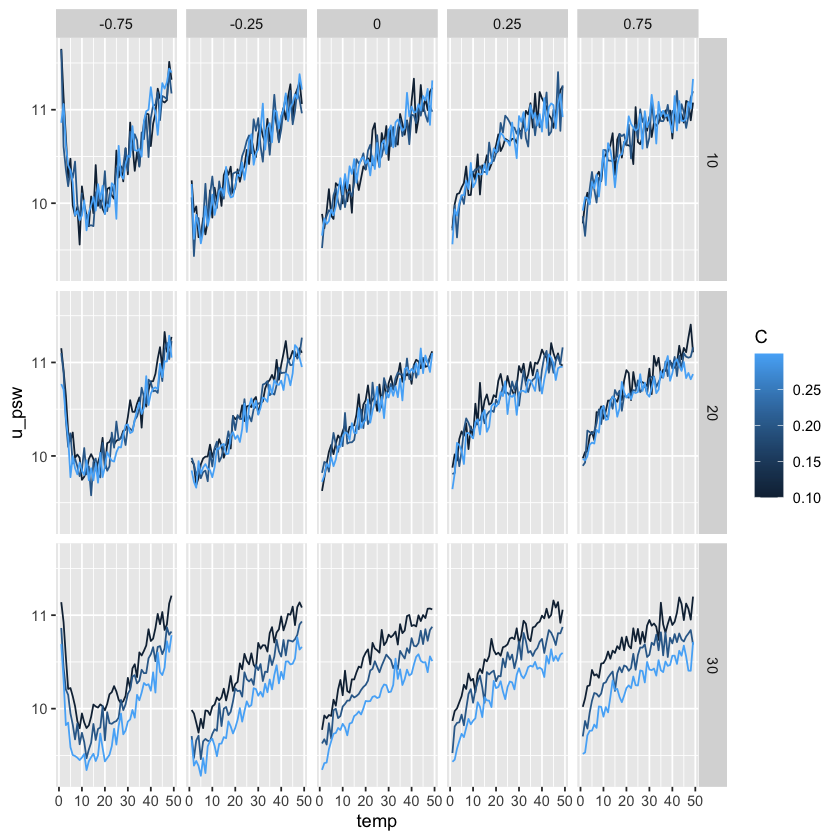

In [200]:
bs_df %>%
    filter(treat == 0, time == 1, temp != 50) %>%
    # pivot_wider(names_from = treat, values_from = psw ) %>%
    # mutate(diff = `0` - `1`) %>%
    group_by(N,treat,temp,C,a) %>%
    summarise(u_psw = mean(psw)) %>%
    ggplot(aes(temp, u_psw, group = C, color = C)) +
        geom_line()+
        facet_grid(N~a)

In [193]:
bs_df %>%
    filter(time == 1, temp != 50) %>%
    # pivot_wider(names_from = treat, values_from = psw ) %>%
    # mutate(diff = `0` - `1`) %>%
    group_by(N,treat,temp,C,a) %>%
    summarise(u_psw = mean(psw))

`summarise()` has grouped output by 'N', 'treat', 'temp', 'C'. You can override using the `.groups` argument.


N,treat,temp,C,a,u_psw
<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
10,0,1,0.1,-0.75,11.650756
10,0,1,0.1,-0.25,10.244274
10,0,1,0.1,0.00,9.885466
10,0,1,0.1,0.25,9.732516
10,0,1,0.1,0.75,9.784359
10,0,1,0.2,-0.75,11.641291
10,0,1,0.2,-0.25,10.063023
10,0,1,0.2,0.00,9.520453
10,0,1,0.2,0.25,9.708881


`summarise()` has grouped output by 'time', 'treat', 'temp', 'N', 'C'. You can override using the `.groups` argument.


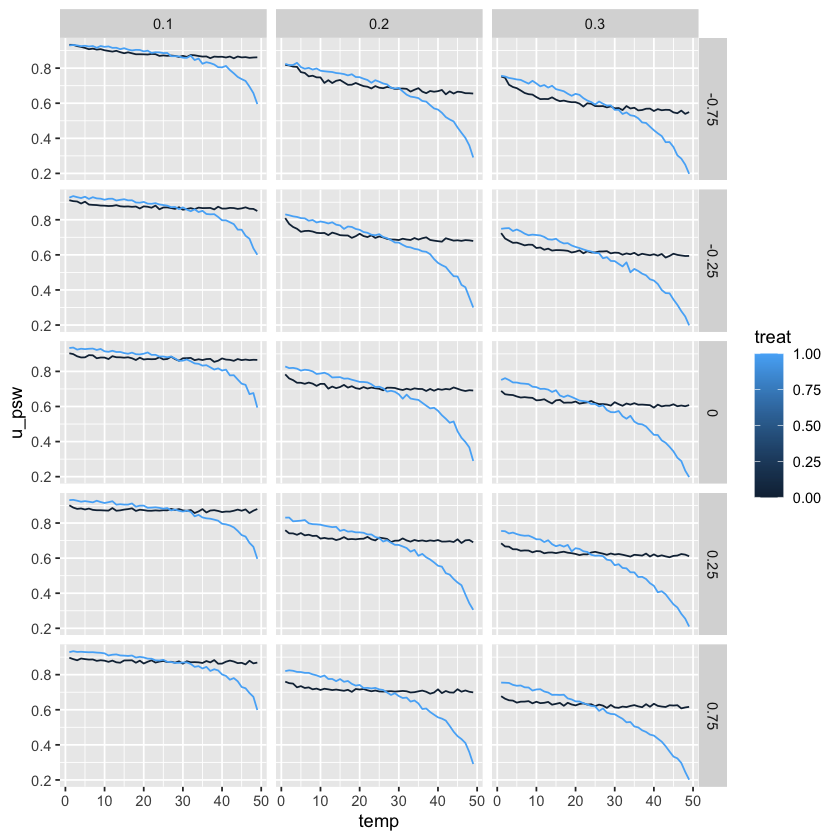

In [125]:
psw_df %>%
    filter(time == 1, temp < 50) %>%
    group_by(time,treat,temp,N,C,a) %>%
    summarise(u_psw = mean(psw)) %>%
    ggplot(aes(temp, u_psw, group = treat, color = treat)) +
        geom_line()+
        facet_grid(a~C)

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`

No summary function supplied, defaulting to `mean_se()`



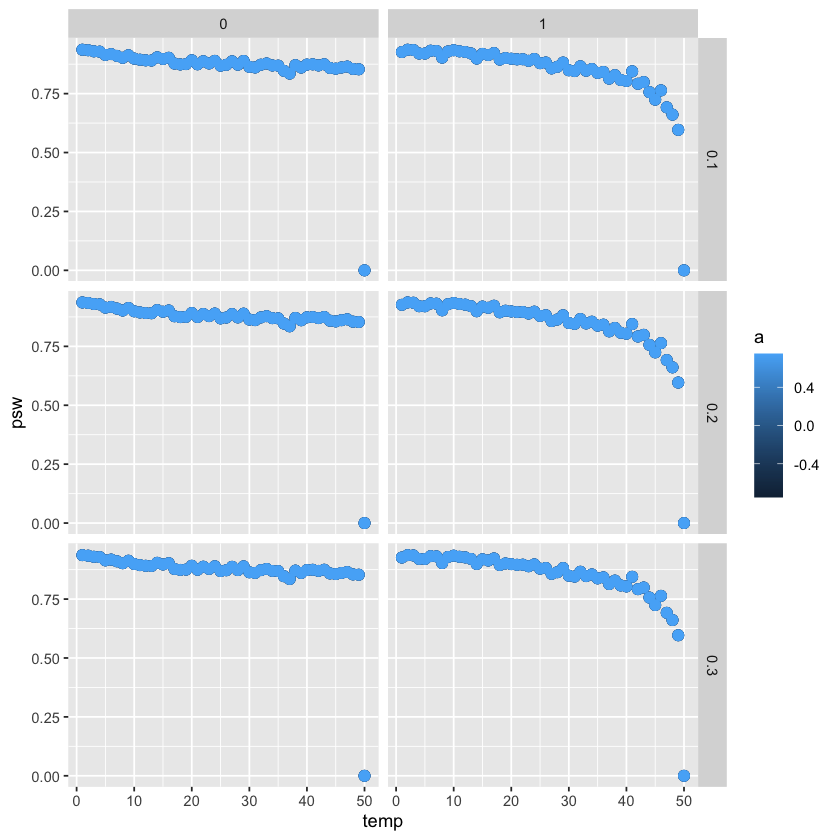

In [102]:
psw_df %>%
    filter(time == 1) %>%
    ggplot(aes(temp, psw, color = a, group = a))+
        # geom_point(alpha = 0.01)+
        stat_summary()+
        facet_grid(C~treat)

In [44]:
df

temp,time,rep,psw
<dbl>,<dbl>,<chr>,<dbl>
0,0,rep_401,0.68
0,0,rep_402,0.82
0,0,rep_403,0.88
0,0,rep_404,0.78
0,0,rep_405,0.92
0,0,rep_406,0.94
0,0,rep_407,1.00
0,0,rep_408,0.82
0,0,rep_409,0.88
